# Tuning Neural Networking in Keras

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-11-lecture-2-tuning-deep-learning-models/blob/main/SOLUTIONS%20Code-along%20Tuning%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

Keras works as weapper for deep learning model to be used as classification or regression estimators in sklearn

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Useful Functions

In [32]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

# Data

We will be using the diabetes dataset from the previous lecture.

**NOTE**

These datasets are very small for deep learning.  Deep learning models usually work best with very large datasets with at least 10,000 or more samples.  They work best on even larger datasets than that.  But, for demonstration we will use these smaller datasets.

In [33]:
## Load data
diabetes = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Classification

Let's start with modeling the classification dataset

In [34]:
## Overall look at data
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
## Check for duplicates
diabetes.duplicated().any()

False

In [36]:
## Look for outliers
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [37]:
## Check class blance
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [38]:
## Data Cleaning
no_glucose = diabetes['Glucose'] == 0
no_blood = diabetes['BloodPressure'] == 0
no_skin = diabetes['SkinThickness'] == 0
no_insulin = diabetes['Insulin'] == 0
no_bmi = diabetes['BMI'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = diabetes[~(no_glucose |
                                     no_blood |
                                     no_skin |
                                     no_insulin |
                                     no_bmi)]
class_df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
# Define X and Y and complete the train test split
X = diabetes.drop(columns = 'Outcome')
y = diabetes['Outcome'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .4, random_state = 42)

## Scaling

Always scale your data for deep learning.  Otherwise you get a problem call 'Exploding Weights'.  Some weights will be updated much faster than others because the inputs are at larger scales.  This tends to hurt learning as data on smaller scales does not update as fast and doesn't get to contribute as much to the decision making process.  By scaling we put all features on the same footing.

In [40]:
# Scale the data
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
X_train

array([[0.        , 0.47236181, 0.        , ..., 0.        , 0.07600342,
        0.06666667],
       [0.47058824, 0.6281407 , 0.78688525, ..., 0.        , 0.06575576,
        0.55      ],
       [0.05882353, 0.55778894, 0.70491803, ..., 0.50673401, 0.02775406,
        0.03333333],
       ...,
       [0.58823529, 0.50753769, 0.70491803, ..., 0.76767677, 0.45175064,
        0.28333333],
       [0.        , 0.70854271, 0.        , ..., 0.71380471, 0.05422716,
        0.13333333],
       [0.        , 0.6281407 , 0.78688525, ..., 0.37878788, 0.07856533,
        0.        ]])

## First Simple Model

We always want to start simple, as deep learning models can get very complex fast and more complex models take more time to train and are more prone to overfitting.  A well performing simple model is better than a well performing complex model.

## Input layer
The first layer we will define is not technically the input layer.  We will define the first hidden layer with a special argument that tells Keras how to create a input layer:

`input_dim=`

Input layers can also be defined manually using tensorflow.keras.layers.InputLayer

## Activation function

For the single hidden layer we will try just 3 nodes and use a ReLU activation.  ReLUs tend to perform well for hidden nodes.

## Output Layer

For out output layer (last layer) we just use one node because we only want the output of the model to be one number.  We will use a sigmoid activation function.  This will simply output the value from the weights and bias in the node with no change.




In [42]:
# Check the shape of input

X_train.shape[1]

8

In [43]:
from keras.metrics import Precision, Recall

In [44]:
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
def build_model1():
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


# Check summary of network
    model.compile(loss='bce', optimizer='adam', metrics=['acc', Precision(), Recall()])
    return model

class_model1 = build_model1()
class_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

Epoch 1/100
15/15 [==============================] - 1s 18ms/step - loss: 0.8520 - acc: 0.3609 - precision: 0.3609 - recall: 1.0000 - val_loss: 0.8456 - val_acc: 0.3312 - val_precision: 0.3312 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.8089 - acc: 0.3609 - precision: 0.3609 - recall: 1.0000 - val_loss: 0.8022 - val_acc: 0.3312 - val_precision: 0.3312 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7747 - acc: 0.3630 - precision: 0.3617 - recall: 1.0000 - val_loss: 0.7661 - val_acc: 0.3377 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7458 - acc: 0.3674 - precision: 0.3632 - recall: 1.0000 - val_loss: 0.7371 - val_acc: 0.3474 - val_precision: 0.3344 - val_recall: 0.9804
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7232 - acc: 0.3761 - precision: 0.3628 - recall: 0.9639 - val_loss: 0.71

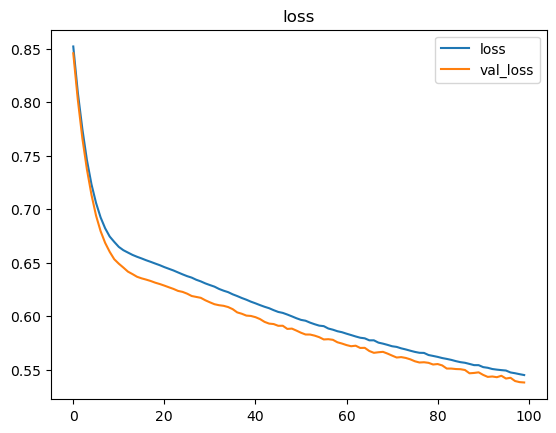

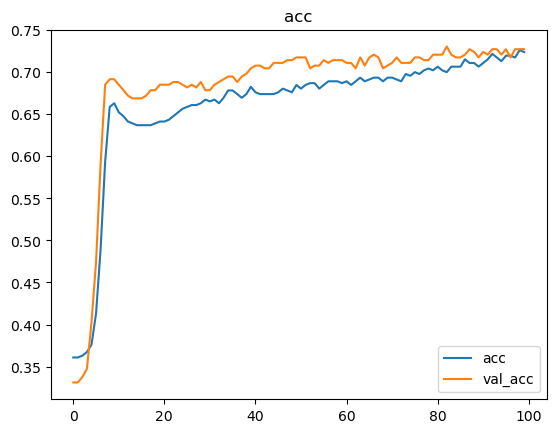

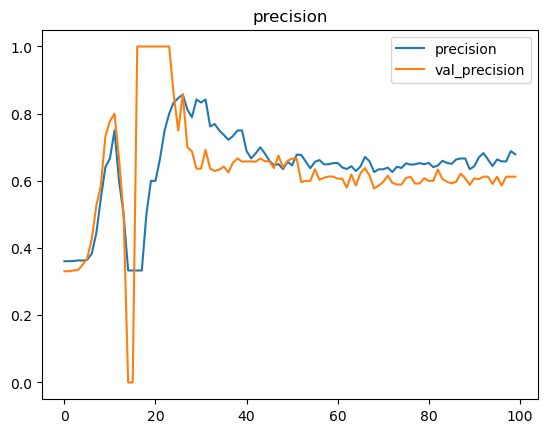

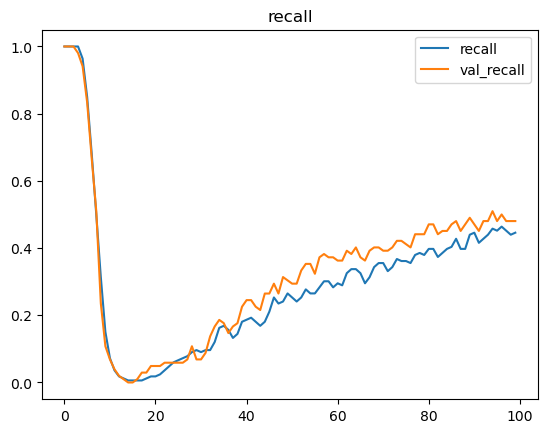

In [45]:
# Fit your model
history = class_model1.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=100)

plot_history(history)

In [47]:
class_model1.predict(X_train)

15/15 [==============================] - 0s 738us/step


array([[0.23974983],
       [0.38649803],
       [0.16057952],
       [0.62640727],
       [0.6303835 ],
       [0.16774951],
       [0.24895155],
       [0.21365674],
       [0.6039563 ],
       [0.29760402],
       [0.19075419],
       [0.18733092],
       [0.5135069 ],
       [0.34493154],
       [0.6546969 ],
       [0.32329595],
       [0.34891105],
       [0.39295092],
       [0.2059012 ],
       [0.3451944 ],
       [0.49481717],
       [0.17016657],
       [0.21674158],
       [0.21512896],
       [0.17556174],
       [0.61931974],
       [0.38453814],
       [0.19466904],
       [0.7257374 ],
       [0.65707797],
       [0.20853864],
       [0.2888704 ],
       [0.34013155],
       [0.23109855],
       [0.31405127],
       [0.5312681 ],
       [0.55851907],
       [0.71848434],
       [0.16825208],
       [0.3466497 ],
       [0.29616028],
       [0.5203345 ],
       [0.21085897],
       [0.37652895],
       [0.90245324],
       [0.632693  ],
       [0.36912102],
       [0.439

10/10 [==============================] - 0s 1ms/step
model1_train 

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       294
           1       0.68      0.46      0.55       166

    accuracy                           0.73       460
   macro avg       0.71      0.67      0.68       460
weighted avg       0.72      0.73      0.71       460



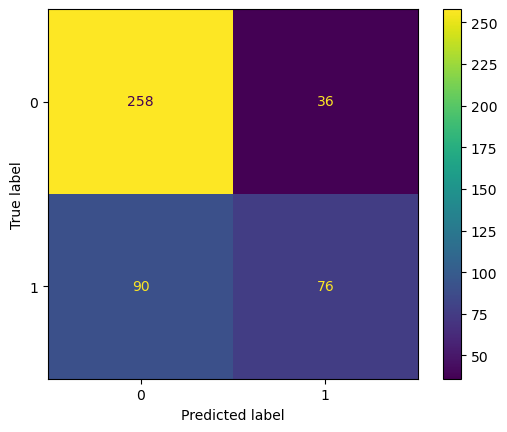

model1_test 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       206
           1       0.61      0.48      0.54       102

    accuracy                           0.73       308
   macro avg       0.69      0.66      0.67       308
weighted avg       0.72      0.73      0.72       308



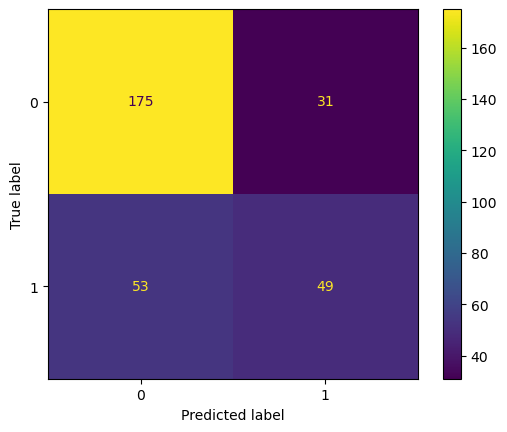

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
model1_train,0.678571,0.457831,0.546763,0.726087
model1_test,0.612500,0.480392,0.538462,0.727273


In [48]:
# Apply the custom function to see how your model is doing
train_preds = np.rint(class_model1.predict(X_train))
test_preds = np.rint(class_model1.predict(X_test))

train_scores = eval_classification(y_train, train_preds, name='model1_train')
test_scores = eval_classification(y_test, test_preds, name='model1_test')

scores = pd.concat([train_scores, test_scores])
scores

## Evaluation


In [ ]:
## Evaluate model




# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 2nd Model

In [50]:
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
def build_model2():
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))


# Check summary of network
    model.compile(loss='bce', optimizer='adam', metrics=['acc', Precision(), Recall()])
    return model

class_model2 = build_model2()
class_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                90        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




In [ ]:
# Compile your model.




# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

Epoch 1/100
15/15 [==============================] - 1s 20ms/step - loss: 0.6832 - acc: 0.6391 - precision_2: 0.5000 - recall_2: 0.0060 - val_loss: 0.6750 - val_acc: 0.6656 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6740 - acc: 0.6391 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6645 - val_acc: 0.6688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6676 - acc: 0.6391 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6570 - val_acc: 0.6688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6632 - acc: 0.6391 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6521 - val_acc: 0.6688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 4ms

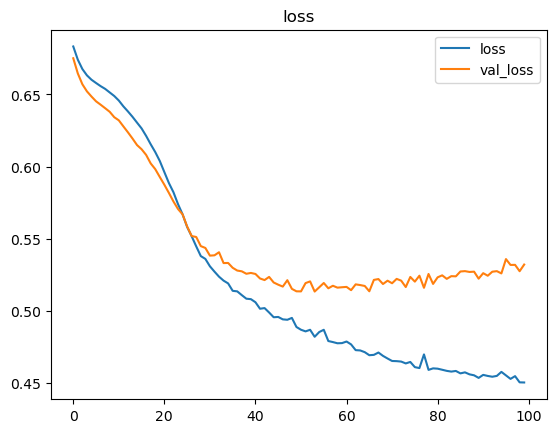

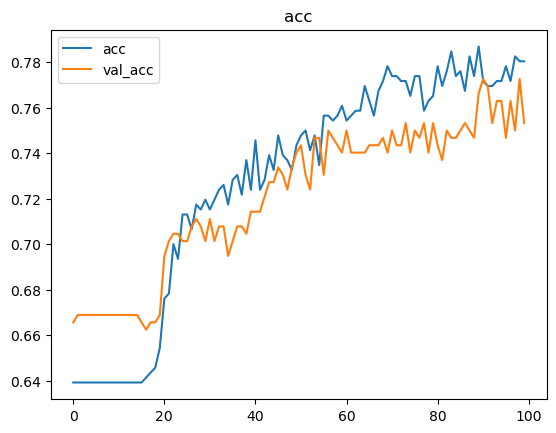

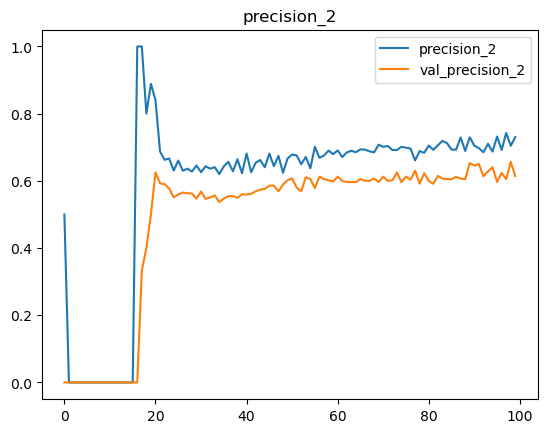

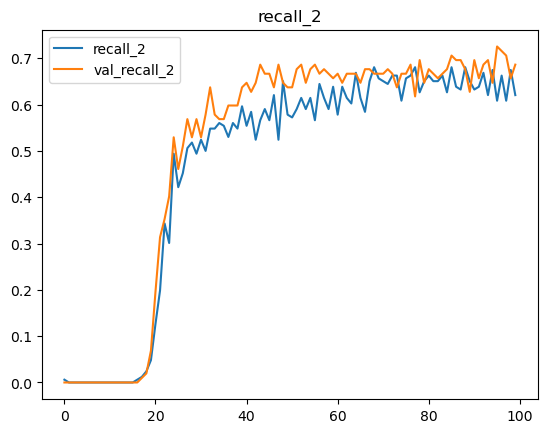

In [51]:
# Fit your model
history = class_model2.fit(X_train, y_train,
                           validation_data=(X_test, y_test),
                           epochs=100)


plot_history(history)

In [ ]:
# Apply the custom function to see how your model is doing



## Evaluation


10/10 [==============================] - 0s 896us/step
class_model2 Train 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       294
           1       0.72      0.66      0.69       166

    accuracy                           0.79       460
   macro avg       0.77      0.76      0.76       460
weighted avg       0.78      0.79      0.78       460



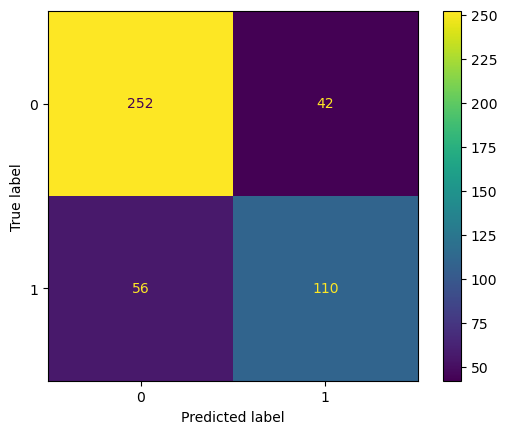

class_model2 Test 

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       206
           1       0.61      0.69      0.65       102

    accuracy                           0.75       308
   macro avg       0.72      0.74      0.73       308
weighted avg       0.76      0.75      0.76       308



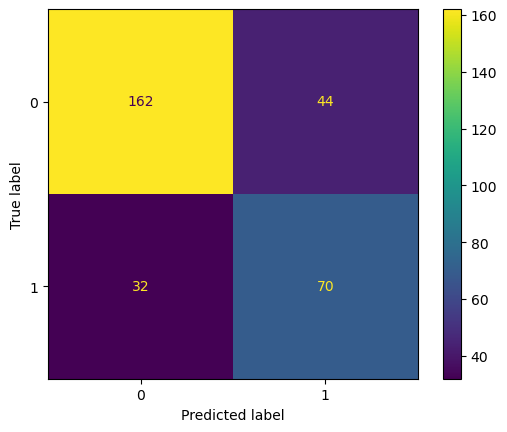

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
model1_train,0.678571,0.457831,0.546763,0.726087
model1_test,0.612500,0.480392,0.538462,0.727273
class_model2 Train,0.723684,0.662651,0.691824,0.786957
class_model2 Test,0.614035,0.686275,0.648148,0.753247


In [52]:
## Evaluate model

train_pred = np.rint(class_model2.predict(X_train))
test_preds = np.rint(class_model2.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='class_model2 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='class_model2 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 3rd Model

In [53]:
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
def build_model3():
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, activation='sigmoid'))


# Check summary of network
    model.compile(loss='bce', optimizer='adam', metrics=['acc', Precision(), Recall()])
    return model

class_model3 = build_model3()
class_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                90        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 10)               

## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [54]:
# Fit your model

history = class_model3.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100)


Epoch 1/100
15/15 [==============================] - 1s 21ms/step - loss: 0.6833 - acc: 0.6217 - precision_3: 0.4429 - recall_3: 0.1867 - val_loss: 0.6754 - val_acc: 0.6656 - val_precision_3: 0.3333 - val_recall_3: 0.0098
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6721 - acc: 0.6413 - precision_3: 0.6000 - recall_3: 0.0181 - val_loss: 0.6626 - val_acc: 0.6688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6636 - acc: 0.6348 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.6521 - val_acc: 0.6688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 0.6614 - acc: 0.6391 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.6450 - val_acc: 0.6688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.

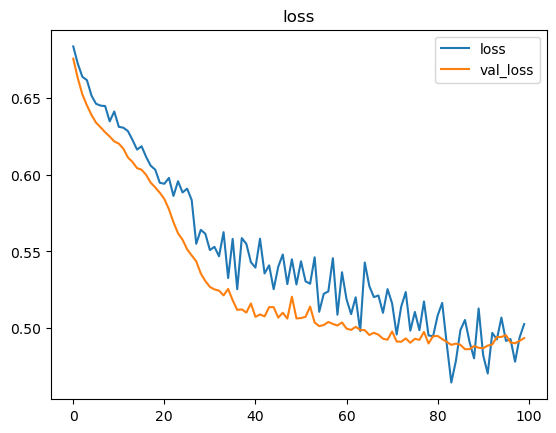

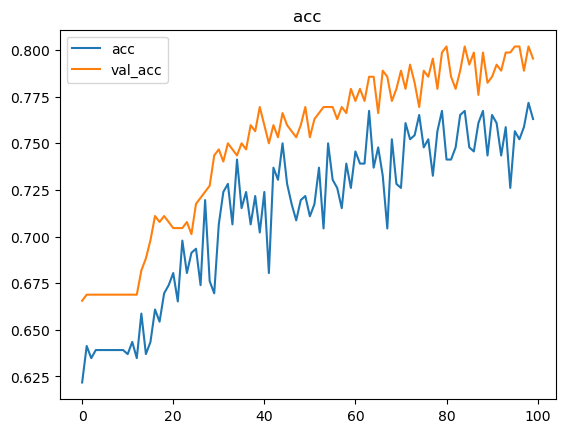

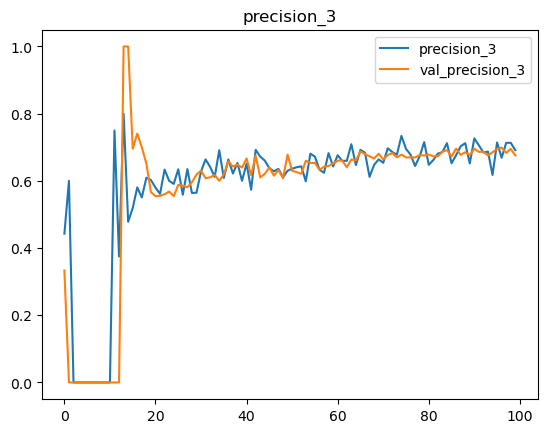

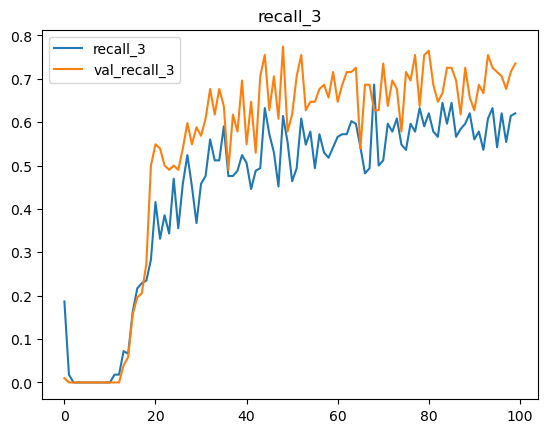

In [55]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


10/10 [==============================] - 0s 835us/step
class_model3 Train 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       294
           1       0.76      0.67      0.71       166

    accuracy                           0.80       460
   macro avg       0.79      0.77      0.78       460
weighted avg       0.80      0.80      0.80       460



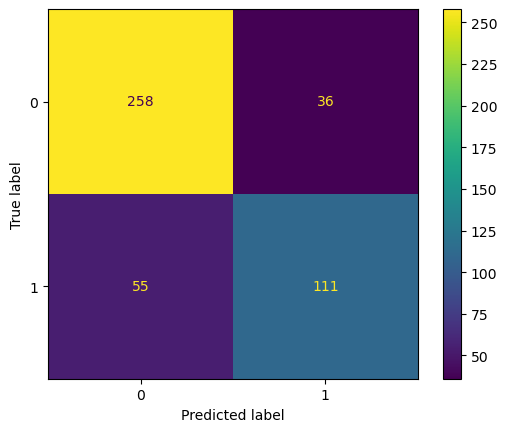

class_model3 Test 

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       206
           1       0.68      0.74      0.70       102

    accuracy                           0.80       308
   macro avg       0.77      0.78      0.77       308
weighted avg       0.80      0.80      0.80       308



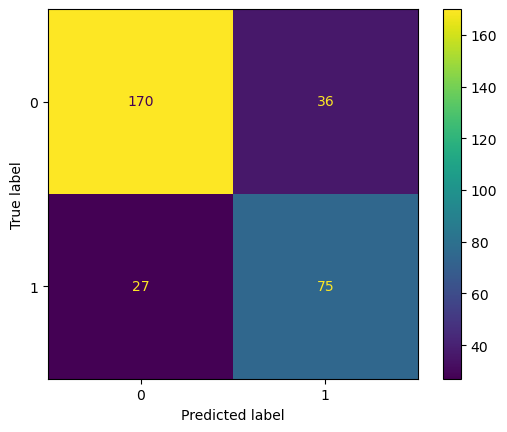

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
model1_train,0.678571,0.457831,0.546763,0.726087
model1_test,0.612500,0.480392,0.538462,0.727273
class_model2 Train,0.723684,0.662651,0.691824,0.786957
class_model2 Test,0.614035,0.686275,0.648148,0.753247
class_model3 Train,0.755102,0.668675,0.709265,0.802174
class_model3 Test,0.675676,0.735294,0.704225,0.795455


In [56]:
## Evaluate model

train_pred = np.rint(class_model3.predict(X_train))
test_preds = np.rint(class_model3.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='class_model3 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='class_model3 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

# <center> Attack Bias or Variance? </center>

How should we tune this classification model?

# Improving ANN - 4t Model

In [57]:
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
def build_model4():
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, activation='sigmoid'))


# Check summary of network
    model.compile(loss='bce', optimizer='adam', metrics=['acc', Precision(), Recall()])
    return model

class_model4 = build_model4()
class_model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 100)               900       
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 100)              

## Compiling

Compiling the model puts all the pieces together to make it ready to train.  We need to specify:

* **Optimizer:** An Adam optimizer is a favorite and often performs well, it's a good place to start.
  - Other optimizers : Gradient Descent,Stochastic Gradient Descent,Adagrad,RMSProp
* **Loss Function:** 'mse' or mean squared error.  This is the number our model will try to reduce in each epoch.  Since this is a regression model we want our model to minimize the mean squared error.
* **Metrics:** 'mae' or mean absolute error.  We can provide a list of any appropriate metrics we want the model to keep track at each epoch.




# Training

Let's try training our model for 100 few epochs.  Sometimes that is enough, and it will give us an idea whether our model is learning anything.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
# Fit your model

#Early Stopping?
early_stop = EarlyStopping(patience=3)

history = class_model4.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        # callbacks=[early_stop]
                          )


Epoch 1/100
15/15 [==============================] - 0s 8ms/step - loss: 0.4634 - acc: 0.7565 - precision_4: 0.6627 - recall_4: 0.6627 - val_loss: 0.4775 - val_acc: 0.7825 - val_precision_4: 0.7536 - val_recall_4: 0.5098
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4560 - acc: 0.7696 - precision_4: 0.6948 - recall_4: 0.6446 - val_loss: 0.4689 - val_acc: 0.7857 - val_precision_4: 0.6875 - val_recall_4: 0.6471
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.4341 - acc: 0.7717 - precision_4: 0.7133 - recall_4: 0.6145 - val_loss: 0.4840 - val_acc: 0.7695 - val_precision_4: 0.6260 - val_recall_4: 0.7549
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4184 - acc: 0.8109 - precision_4: 0.7724 - recall_4: 0.6747 - val_loss: 0.4801 - val_acc: 0.7662 - val_precision_4: 0.6210 - val_recall_4: 0.7549
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4125 - acc: 0.7783 - precision_4: 0.7025 

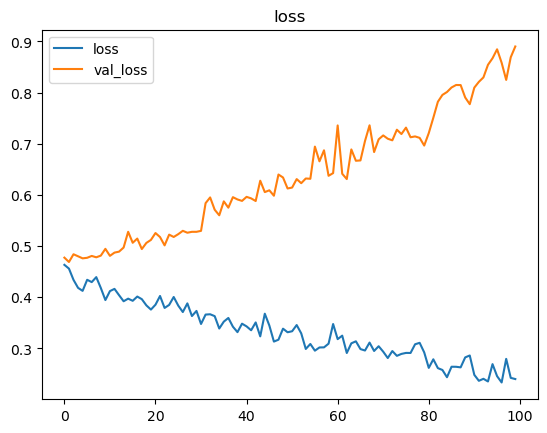

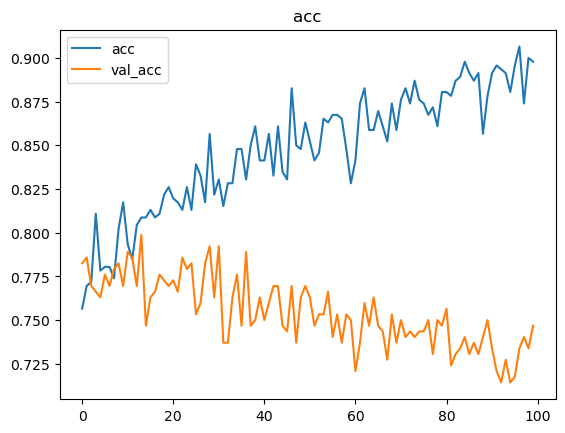

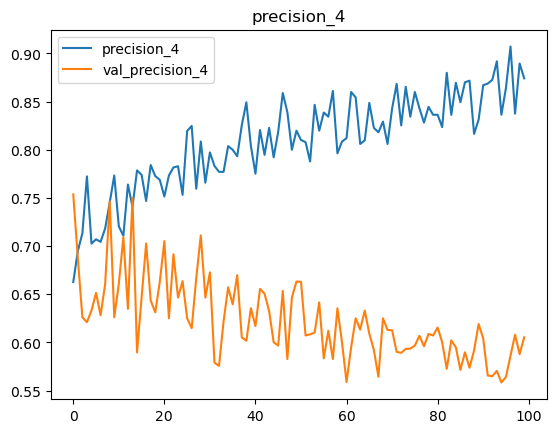

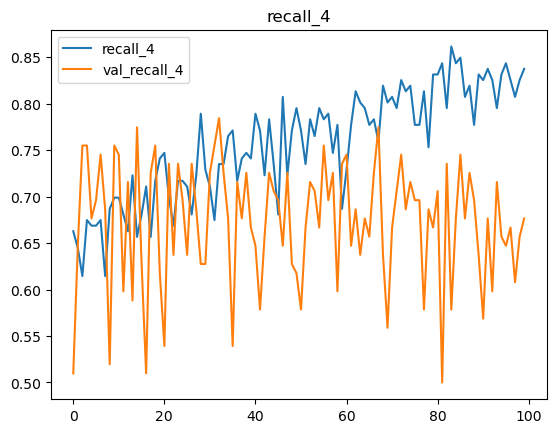

In [61]:
# Apply the custom function to see how your model is doing
plot_history(history)

## Evaluation


10/10 [==============================] - 0s 889us/step
class_model4 Train 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       294
           1       0.94      0.87      0.90       166

    accuracy                           0.93       460
   macro avg       0.93      0.92      0.92       460
weighted avg       0.93      0.93      0.93       460



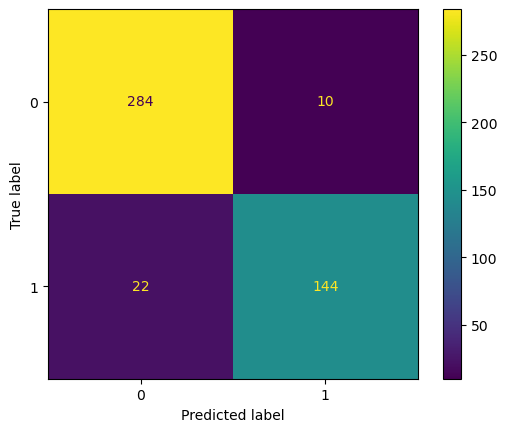

class_model4 Test 

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       206
           1       0.61      0.68      0.64       102

    accuracy                           0.75       308
   macro avg       0.72      0.73      0.72       308
weighted avg       0.76      0.75      0.75       308



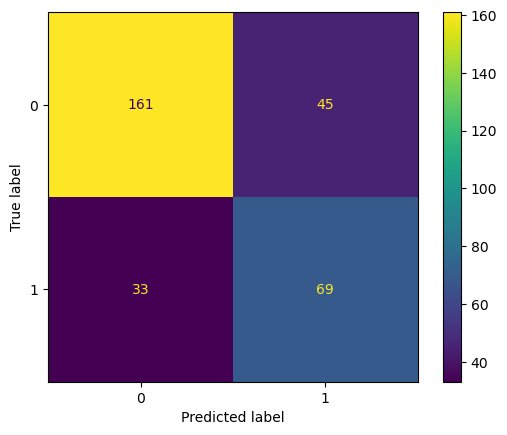

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
model1_train,0.678571,0.457831,0.546763,0.726087
model1_test,0.612500,0.480392,0.538462,0.727273
class_model2 Train,0.723684,0.662651,0.691824,0.786957
class_model2 Test,0.614035,0.686275,0.648148,0.753247
class_model3 Train,0.755102,0.668675,0.709265,0.802174
class_model3 Test,0.675676,0.735294,0.704225,0.795455
class_model4 Train,0.935065,0.867470,0.900000,0.930435
class_model4 Test,0.605263,0.676471,0.638889,0.746753


In [62]:
## Evaluate model

train_pred = np.rint(class_model4.predict(X_train))
test_preds = np.rint(class_model4.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='class_model4 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='class_model4 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores